# Checksum Validation and Verification ( adler32 )

- **Validation**: 
    - For the DIDs that were present in both, rucio dumps and seal dumps, we will first make sure that SEAL has provided the checksums for all the DIDs that were uploaded to the storage element and were claimed to be available by SEAL. These DIDs are the ones that are present in the rucio dumps and the seal dumps.
    - We will then report the DIDs for which the checksums are missing in the seal dumps. SEAL must provide the checksums for these missing DIDs in order to verify the integrity of the data.

- **Verification**: For the subset of DIDs that are available in both the rucio dumps and the seal dumps and have the checksums available in the seal dumps, we will verify the checksums in Rucio against the checksums provided by SEAL.

## Time Range
We need to pick a time range used to filter the DIDs from the dumps. The end time is limited by the fact that we do not have all the checksums for the DIDs in the SEAL dumps after a certain time. We will use the following time range for the analysis:

In [3]:
from datetime import datetime
date_start_str = '20220101' # YYYYMMDD
date_end_str = '20220801' # YYYYMMDD

date_start = datetime.strptime(date_start_str, '%Y%m%d')
date_end = datetime.strptime(date_end_str, '%Y%m%d')

# Checksum Validation

In this section, we will process the checksums from the Rucio and SEAL dumps to make them comparable. As a reminder, we prepare a subset of the consistent DIDs for which checksums are available from Rucio and SEAL.

## Checksums calculated by SEAL

The `data/seal/checksums/entries_{start_date}_{end_date}.csv` file contains the checksums (adler32, md5, sha256) calculated by SEAL for the DIDs available on their storage. 


In [51]:
import pandas as pd
from core.utils import bytesToTB
dir = 'data/seal/checksums'
entries_file = f'{dir}/entries_{date_start_str}_{date_end_str}.csv'

entries = pd.read_csv(entries_file)
entries['path'] = entries['path'].str.replace('rucio/', '')

total_size_entries = entries['size_bytes'].sum()

print(f'Num Entries: {entries.shape[0]}')
print(f'Total Size: {bytesToTB(total_size_entries)} TB')

Num Entries: 516978
Total Size: 343.429 TB


The `data/seal/checksums/errors_{start_date}_{end_date}.csv` file contains entries that for which the checksum could not be calculated by SEAL and the specific errors that occurred.

- Most of the errors indicate 404 Not Found, which means SEAL has data for the file, but the last few chunks did not complete transfer
- Entries with a 500 Internal Server Error are essentially the same as the 404, but the in addition the to the chunk(s) missing, the metadata record could not be found

In [52]:
errors_file = f'data/seal/checksums/errors_{date_start_str}_{date_end_str}.csv'
errors = pd.read_csv(errors_file, index_col=False)
errors['path'] = errors['path'].str.replace('rucio/', '')
print(f'Num Errors: {errors.shape[0]}')

Num Errors: 4387


/var/folders/0x/zbc_xnv17ggfqczysm3_5g_80000gn/T/ipykernel_7546/1874277347.py:2: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  errors = pd.read_csv(errors_file, index_col=False)


## Checksums stored by Rucio

We will load the consistent did's ( subset of rucio dumps ) and filter for rows for the selected time range. The consistent did's are the ones that are present in both the rucio dumps and the seal dumps. This file was prepared in the `manual_auditor` notebook.

In [53]:
consistent_dids_file = f'data/outputs/consistent_dids_20220101-20230410.csv'
consistent_dids = pd.read_csv(consistent_dids_file)

consistent_dids['creation_date'] = pd.to_datetime(consistent_dids['creation_date'])
consistent_dids['update_date'] = pd.to_datetime(consistent_dids['update_date'])
consistent_dids['size'] = pd.to_numeric(consistent_dids['size'])

print(f'Num Consistent DIDs: {consistent_dids.shape[0]}')

Num Consistent DIDs: 2654663


Now, we filter the consistent did's for the selected time range.

In [54]:
consistent_dids_in_time_range = consistent_dids[(consistent_dids['creation_date'] <= date_end)]

print(f'Num Consistent DIDs in Date Range: {consistent_dids_in_time_range.shape[0]}')

Num Consistent DIDs in Date Range: 793013


## Missing Checksums from SEAL

The `consistent_dids_in_time_range` DataFrame contains the DIDs that are present in both the rucio dumps and the seal dumps in the selected time range. Therefore, the DIDs provided by SEAL in their `entries` and `errors` DataFrames should also be present in the `consistent_dids_in_time_range` DataFrame ( except for the `dark_dids`). We will check if this is the case.

The entries that are present in the `consistent_dids_in_time_range` file but are not present in the `entries` or `errors` files are missing checksums from SEAL. We will check if there are any such entries.

In [55]:
dids_missing_checksums = consistent_dids_in_time_range[~consistent_dids_in_time_range['path'].isin(entries['path'])]
print(f"DIDs missing in entries file: {len(dids_missing_checksums)}")
# check if the dids missing checksums are not in the errors

dids_missing_checksums = dids_missing_checksums[~dids_missing_checksums['path'].isin(errors['path'])]

print(f'Num Missing Checksums from SEAL: {len(dids_missing_checksums)}')



DIDs missing in entries file: 276044
Num Missing Checksums from SEAL: 271658


## Validation Summary

In [83]:
print(f"For the time range {date_start} to {date_end}: {bytesToTB(consistent_dids_in_time_range['size'].sum())} TB registered in Rucio were available at SEAL.")
print(f"Of these, valid checksums were provided by SEAL for {bytesToTB(entries['size_bytes'].sum())} TB. SEAL could not generate checksums for {bytesToTB(errors['size_bytes'].sum())} TB and these files should be marked as lost.")
print(f"{bytesToTB(dids_missing_checksums['size'].sum())} TB were missing checksums from SEAL.")
print(f"Checksum verification can only be done for {bytesToTB(consistent_dids_in_time_range['size'].sum()) - bytesToTB(dids_missing_checksums['size'].sum()) - bytesToTB(errors['size_bytes'].sum())}/{bytesToTB(consistent_dids_in_time_range['size'].sum())} TB.")

For the time range 2022-01-01 00:00:00 to 2022-08-01 00:00:00: 474.409 TB registered in Rucio were available at SEAL.
Of these, valid checksums were provided by SEAL for 343.429 TB. SEAL could not generate checksums for 26.548 TB and these files should be marked as lost.
104.433 TB were missing checksums from SEAL.
Checksum verification can only be done for 343.428/474.409 TB.


In [84]:
print(f"For the time range {date_start} to {date_end}: {len(consistent_dids_in_time_range)} DIDs registered in Rucio were available at SEAL.")
print(f"Of these, valid checksums were provided by SEAL for {len(entries)} DIDs. SEAL could not generate checksums for {len(errors)} DIDs and these files should be marked as lost.")
print(f"{len(dids_missing_checksums)} DIDs were missing checksums from SEAL.")
print(f"Checksum verification can only be done for {len(consistent_dids_in_time_range) - len(dids_missing_checksums) - len(errors)}/{len(consistent_dids_in_time_range)} DIDs.")

For the time range 2022-01-01 00:00:00 to 2022-08-01 00:00:00: 793013 DIDs registered in Rucio were available at SEAL.
Of these, valid checksums were provided by SEAL for 516978 DIDs. SEAL could not generate checksums for 4387 DIDs and these files should be marked as lost.
271658 DIDs were missing checksums from SEAL.
Checksum verification can only be done for 516968/793013 DIDs.


Text(0.5, 1.0, 'Total: 474.409 TB')

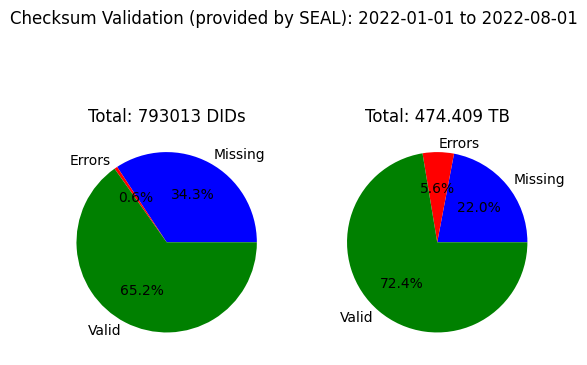

In [85]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2)

fig.suptitle(f'Checksum Validation (provided by SEAL): {date_start.strftime("%Y-%m-%d")} to {date_end.strftime("%Y-%m-%d")}')

axs[0].pie([len(dids_missing_checksums), len(errors), len(entries)], labels=['Missing', 'Errors', 'Valid'], autopct='%1.1f%%', colors=['blue', 'red', 'green'])
axs[0].set_title(f'Total: {len(consistent_dids_in_time_range)} DIDs')

axs[1].pie([bytesToTB(dids_missing_checksums['size'].sum()), bytesToTB(errors['size_bytes'].sum()), bytesToTB(entries['size_bytes'].sum())], labels=['Missing', 'Errors', 'Valid'], autopct='%1.1f%%', colors=['blue', 'red', 'green'])
axs[1].set_title(f'Total: {bytesToTB(consistent_dids_in_time_range["size"].sum())} TB')


In [86]:
missing_checksums_filename = f'data/outputs/dids_missing_checksums_{date_start_str}-{date_end_str}.csv'
dids_missing_checksums.to_csv(missing_checksums_filename, index=False)
print(f"Missing checksums DIDs written to {missing_checksums_filename}")

Missing checksums DIDs written to data/outputs/dids_missing_checksums_20220101-20220801.csv


# Checksum Verification

This section summarizes the checksum verification ( NOT VALIDATION) results. The verification process takes the validated checksums and checks if the checksum reported by Rucio and SEAL actually match.

In [87]:
checksum_verification_df = consistent_dids_in_time_range[consistent_dids_in_time_range['path'].isin(entries['path'])]
print(f"For the time range {date_start} to {date_end}:")
print(f"Checksum verification can be done for {checksum_verification_df.shape[0]} DIDs.")

For the time range 2022-01-01 00:00:00 to 2022-08-01 00:00:00:
Checksum verification can be done for 516969 DIDs.


In [62]:
df_merged_checksum_data = checksum_verification_df.merge(entries, on='path')
df_merged_checksum_data['checksum_match'] = df_merged_checksum_data['checksum'] == df_merged_checksum_data['hash_adler32']

# count the number of checksums that match
df_verified_replicas = df_merged_checksum_data[df_merged_checksum_data['checksum_match'] == True]
df_bad_replicas = df_merged_checksum_data[df_merged_checksum_data['checksum_match'] == False]

checksum_match_count = df_verified_replicas.shape[0]
checksum_mismatch_count = df_bad_replicas.shape[0]


## Analysis by Number of DIDs

In [75]:
print(f"Checksum verification results ( number of DIDs ):")
print(f"Time Range {date_start} to {date_end}")

num_potential_checksum_verification = len(consistent_dids_in_time_range)
num_missing_checksums = len(dids_missing_checksums)
num_errors = len(errors)
num_verifiable = checksum_verification_df.shape[0]
num_verified_checksums = checksum_match_count
num_mismatch_checksums = checksum_mismatch_count



print(f"Potential DIDs for checksum verification: {num_potential_checksum_verification}")
print(f"Missing checksum information: {num_missing_checksums}")
print(f"Errors: {num_errors}")
print(f"Total verifiable DIDs: {num_verifiable}")
print(f"Verified Replicas (matching checksums): {num_verified_checksums}")
print(f"Checksum Mismatch: {num_mismatch_checksums}")

Checksum verification results ( number of DIDs ):
Time Range 2022-01-01 00:00:00 to 2022-08-01 00:00:00
Potential DIDs for checksum verification: 793013
Missing checksum information: 271658
Errors: 4387
Total verifiable DIDs: 516969
Verified Replicas (matching checksums): 515208
Checksum Mismatch: 1761


## Analysis by Size of DIDs

In [76]:
print(f"Checksum Verification Results (Size): ")
print(f"Time Range {date_start} to {date_end}")

size_potential_checksum_verification = bytesToTB(consistent_dids_in_time_range['size'].sum())
size_missing_checksum = bytesToTB(dids_missing_checksums['size'].sum())
size_errors = bytesToTB(errors['size_bytes'].sum())
size_verifiable = bytesToTB(checksum_verification_df['size'].sum())
size_verified = bytesToTB(df_verified_replicas['size_x'].sum())
size_mismatch = bytesToTB(df_bad_replicas['size_x'].sum())

print(f"Potential size for checksum verification: {size_potential_checksum_verification} TB")
print(f"Missing Checksum Info for : {size_missing_checksum} TB")
print(f"Errors: {size_errors} TB")
print(f"Total verifiable size: {size_verifiable} TB")
print(f"Verified Size (matching checksums): {size_verified} TB")
print(f"Checksum Mismatch: {size_mismatch} TB")

Checksum Verification Results (Size): 
Time Range 2022-01-01 00:00:00 to 2022-08-01 00:00:00
Potential size for checksum verification: 474.409 TB
Missing Checksum Info for : 104.433 TB
Errors: 26.548 TB
Total verifiable size: 343.428 TB
Verified Size (matching checksums): 342.589 TB
Checksum Mismatch: 0.839 TB


## Plots

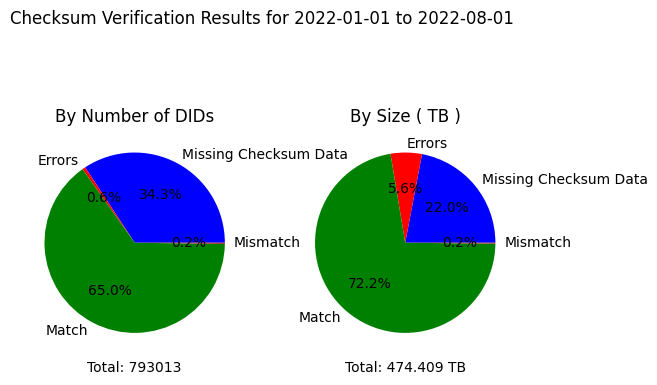

In [82]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2)
fig.suptitle(f"Checksum Verification Results for {date_start.strftime('%Y-%m-%d')} to {date_end.strftime('%Y-%m-%d')}")

axs[0].title.set_text('By Number of DIDs')
axs[0].pie([num_missing_checksums, num_errors, num_verified_checksums, num_mismatch_checksums], labels=['Missing Checksum Data', 'Errors', 'Match', 'Mismatch'], colors=['blue', 'red', 'green', 'brown'], autopct='%1.1f%%')
axs[0].xaxis.set_label_text('Total: ' + str(num_potential_checksum_verification))

axs[1].title.set_text('By Size ( TB )')
axs[1].pie([size_missing_checksum, size_errors, size_verified, size_mismatch], labels=['Missing Checksum Data', 'Errors', 'Match', 'Mismatch'], colors=['blue', 'red', 'green', 'brown'], autopct='%1.1f%%')
axs[1].xaxis.set_label_text(f'Total: {size_potential_checksum_verification} TB')


plt.show()